In [229]:
import pandas as pd
import numpy as np
import math
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import warnings
import calendar
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from geopy.distance import great_circle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import f1_score, recall_score,roc_auc_score, confusion_matrix,mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.width', 1000)


In [175]:
listings_details = pd.read_csv('listings_details.csv')
listings_details.head()


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,2.019030e+13,3/12/19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,This is a totally separate apartment located o...,Fully separate apartment in a two apartment bu...,none,"Mostly quiet ( no loud music, no crowed sidewa...",...,f,f,super_strict_30,f,f,1,1,0,0,0.34
1,5506,https://www.airbnb.com/rooms/5506,2.019030e+13,3/12/19,**$79 Special ** Private! Minutes to center!,This is a private guest room with private bath...,**THE BEST Value in BOSTON!!*** PRIVATE GUEST ...,This is a private guest room with private bath...,none,"Peacful, Architecturally interesting, historic...",...,t,f,strict_14_with_grace_period,f,f,6,6,0,0,0.67
2,6695,https://www.airbnb.com/rooms/6695,2.019030e+13,3/12/19,$99 Special!! Home Away! Condo,NaN,** WELCOME *** FULL PRIVATE APARTMENT In a His...,** WELCOME *** FULL PRIVATE APARTMENT In a His...,none,"Peaceful, Architecturally interesting, histori...",...,t,f,strict_14_with_grace_period,f,f,6,6,0,0,0.73
3,6976,https://www.airbnb.com/rooms/6976,2.019030e+13,3/12/19,Mexican Folk Art Haven in Boston Residential Area,Come stay with me in Boston's Roslindale neigh...,"This is a well-maintained, two-family house bu...",Come stay with me in Boston's Roslindale neigh...,none,The LOCATION: Roslindale is a safe and diverse...,...,f,f,moderate,t,f,1,0,1,0,0.64
4,8789,https://www.airbnb.com/rooms/8789,2.019030e+13,3/12/19,Curved Glass Studio/1bd facing Park,"Bright, 1 bed with curved glass windows facing...",Fully Furnished studio with enclosed bedroom. ...,"Bright, 1 bed with curved glass windows facing...",none,Beacon Hill is a historic neighborhood filled ...,...,f,f,strict_14_with_grace_period,f,f,10,10,0,0,0.39


# 1. Data Preparation
## 1.1 Data Cleaning

In [176]:
# check shape
print("The dataset has {} rows and {} columns.".format(*listings_details.shape))
# Check duplicates
print("It contains {} duplicates.".format(listings_details.duplicated().sum()))

The dataset has 55501 rows and 106 columns.
It contains 0 duplicates.


In [177]:
most_columns = ["id","last_scraped","description","host_id","host_since","host_location","host_response_time", "host_response_rate",
                 "host_acceptance_rate","host_is_superhost","host_total_listings_count","host_verifications","host_has_profile_pic",
                 "host_identity_verified", "neighbourhood_cleansed", "latitude","longitude","property_type",
                 "room_type","accommodates","bathrooms", "bedrooms","beds","bed_type",'amenities', "square_feet","price",
                 "security_deposit", "cleaning_fee","guests_included","extra_people","minimum_nights","maximum_nights",
                 "has_availability","availability_30","availability_60","availability_90", "number_of_reviews",
                 "number_of_reviews_ltm","review_scores_rating","review_scores_accuracy","review_scores_cleanliness",
                 "review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value",
                 "requires_license","instant_bookable","is_business_travel_ready","cancellation_policy",
                 "require_guest_profile_picture","require_guest_phone_verification","reviews_per_month","calculated_host_listings_count",
       "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms",
       "calculated_host_listings_count_shared_rooms"
       ]


df = listings_details[most_columns].copy()


In [178]:
# Check the empty values in inportant columns
df[['price', 'cleaning_fee', 'security_deposit', 'extra_people']].isna().sum()

# Fillin the empty values
df.cleaning_fee.fillna('$0.00', inplace=True)
df.security_deposit.fillna('$0.00', inplace=True)


In [179]:
# Transform from string to number
df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df.security_deposit = df.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df.extra_people = df.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

#### Fix the outliers of price column

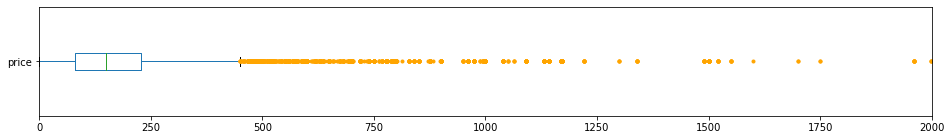

In [180]:
red_square = dict(markerfacecolor='orange', markeredgecolor='orange', marker='.')
df['price'].plot(kind='box', xlim=(0, 2000), vert=False, flierprops=red_square, figsize=(16,2));

- Most the data fell into the interval of \$0  to \$1000, so we decide to consider all the price outside this interval as outliners.

In [181]:
# Delte the outliers
df.drop(df[ (df.price > 1000) | (df.price == 0) ].index, axis=0, inplace=True)

In [182]:
print(df.isna().sum())
df.drop(columns=['square_feet', 'host_response_time', 'host_response_rate', 'review_scores_rating', 'reviews_per_month'], inplace=True)
df.dropna(subset=['host_total_listings_count', 'bathrooms', 'bedrooms', 'beds'], inplace=True)
df.host_has_profile_pic.fillna(value='f', inplace=True)
df.host_is_superhost.fillna(value='f', inplace=True)
df.host_identity_verified.fillna(value='f', inplace=True)
print('------After handling missing values-------')
print(df.isna().sum())


id                                                  0
last_scraped                                        0
description                                       478
host_id                                             0
host_since                                          9
host_location                                     118
host_response_time                              12016
host_response_rate                              12016
host_acceptance_rate                            54940
host_is_superhost                                   9
host_total_listings_count                           9
host_verifications                                  0
host_has_profile_pic                                9
host_identity_verified                              9
neighbourhood_cleansed                              0
latitude                                            0
longitude                                           0
property_type                                       0
room_type                   

In [183]:
df['last_scraped'] = pd.to_datetime(df['last_scraped'])
data1 = df.sort_values(by = ['id','last_scraped'], ascending = False)
last_unique = data1.drop_duplicates(subset ="id", keep = 'first')

df.loc[df['last_scraped']== "7/15/19",'last_scraped'] = "7/14/19"
df.loc[df['last_scraped']== "5/24/19",'last_scraped'] = "5/19/19"
df = df[df['last_scraped'] != "10/11/19"]

## 1.2 Exploratory and descriptive analysis  

In [184]:
df.describe()

,id,host_id,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
count,5.484200e+04,5.484200e+04,0.0,54842.000000,54842.000000,54842.000000,54842.000000,54842.000000,54842.000000,54842.000000,...,43986.000000,44004.000000,43968.000000,44013.000000,43967.000000,43967.000000,54842.000000,54842.000000,54842.000000,54842.000000
mean,2.001556e+07,6.494795e+07,NaN,138.634805,42.339150,-71.083180,3.357409,1.255297,1.325353,1.797801,...,9.587937,9.447937,9.731077,9.679572,9.565970,9.285396,33.836439,31.596769,2.127968,0.099796
std,9.569534e+06,7.110782e+07,NaN,330.707703,0.025929,0.032842,2.110017,0.497007,0.911621,1.266404,...,0.848195,0.914271,0.745511,0.805439,0.760563,0.917698,69.360874,69.871929,4.846488,1.113389
min,3.781000e+03,4.804000e+03,NaN,0.000000,42.235760,-71.178940,1.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,1.333386e+07,1.216519e+07,NaN,1.000000,42.326420,-71.103830,2.000000,1.000000,1.000000,1.000000,...,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000
50%,2.125356e+07,3.052595e+07,NaN,4.000000,42.345080,-71.075720,3.000000,1.000000,1.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,3.000000,1.000000,0.000000,0.000000
75%,2.792239e+07,9.696101e+07,NaN,33.000000,42.355330,-71.061203,4.000000,1.500000,2.000000,2.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,25.000000,18.000000,2.000000,0.000000
max,3.879644e+07,2.963038e+08,NaN,1795.000000,42.398350,-70.969630,25.000000,6.000000,16.000000,24.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,309.000000,309.000000,33.000000,25.000000


### The descriptive statistic for some important variables
![](descriptive statistic for some important variables.png)


#### Price Plot

In [185]:
calendar_df = pd.read_csv('calendar.csv')
calendar_df.date = pd.to_datetime(calendar_df.date)
calendar_df['weekday']= [calendar.day_name[day.weekday()] for day in calendar_df.date]
#calendar_df.boxplot(by = 'weekday', column=['price'], return_type='axes');
calendar_df['price'] = calendar_df['price'].astype('str')
calendar_df['price'] = [float(re.sub('[$, ]', '', i)) for i in calendar_df['price']]
calendar_df.groupby(['weekday']).mean()['price']

weekday
Friday       230.243752
Monday       219.299252
Saturday     231.260390
Sunday       220.286228
Thursday     221.546503
Tuesday      219.101784
Wednesday    219.778612
Name: price, dtype: float64

In [186]:
adp = calendar_df.groupby(['date']).mean()['price']
adp_exp = adp.ewm(span=30, adjust=False).mean()
adp_ma = adp.rolling(window=30).mean()

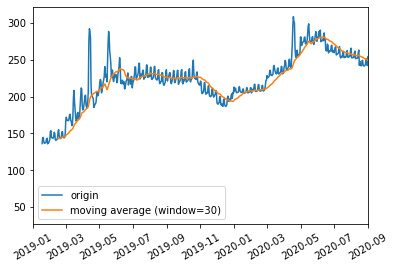

In [187]:
import datetime

plt.figure(1)
plt.plot(adp.index, adp,label='origin')
plt.plot(adp_ma.index, adp_ma, label='moving average (window=30)')
plt.xticks(rotation=30)
plt.xlim([datetime.datetime(2019,1,1), datetime.datetime(2020,9,1)])
plt.legend()
plt.show()

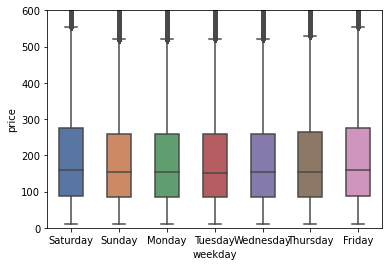

In [188]:
plt.figure(1)
sns.boxplot(y='price', x='weekday', data = calendar_df, width=0.5,palette="deep")
plt.ylim(0,600)
plt.show()

#### Count Airbnb houses in diferent neighborhoods

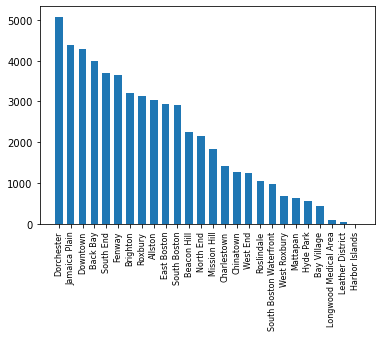

In [189]:
def barplot_count(x):
    '''
    bar plot for raw data x, y -- count
    '''
    plt.figure(np.random.randint(1))
    c = Counter(x)
    c1 = dict([[v,k] for k,v in c.items()])
    c = dict([[c1[v], v] for v in sorted(c.values(), reverse=True)])
    index = np.arange(len(c))
    bar_width = 0.65
    plt.bar(index, c.values(), bar_width)
    plt.xticks(index, c.keys(), fontsize = 8, rotation=90)
    plt.show()
    
barplot_count(df['neighbourhood_cleansed'])   


### The neighborhoods distribution in geographic districts.
![](Bostonmap.png)

We can see that inner harbor area has higher price (Back Bay, West End, Downtown, Chinatown, South Boston). It’s central business area and has a lot of places of interest. It’s popular with tourists and businesspeople. Generally, the far the neighbourhood is from downtown area, the cheaper the daily price would be.

### The Occupancy rate in different geographic districts.

![](Occupancy rate.png)

We can see that North End and East Boston has highest occupancy rate. The reason might be they have relatively low price while not far from the downtown area. Fenway, South Boston Waterfront, West End, Mission hill have low occupancy rate. 

#### Plot the numbers of different rooms

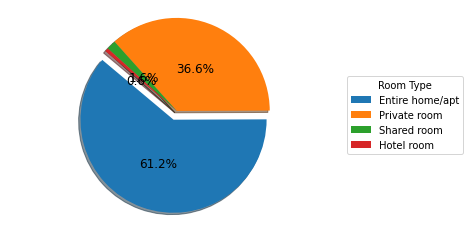

In [190]:
plt.figure(1)
tempD = Counter(last_unique['room_type'])
values = list(tempD.values())
labels = list(tempD.keys())
colors = ['#fd5c63', 'orange', 'lightyellow', 'lightblue']
plt.pie(values, explode = (.1, 0, 0, 0), 
autopct='%1.1f%%', shadow = True, startangle=140, pctdistance = 0.5,
        textprops=dict(color="black", size = 'large'))
plt.legend(labels, title="Room Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.show()

#### Averge prices in months

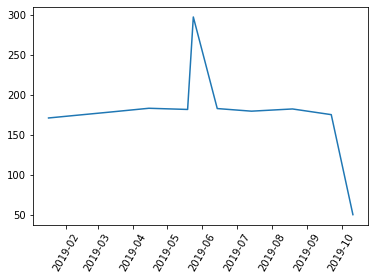

last_scraped
2019-01-17    171.285203
2019-02-09    174.465808
2019-03-12    178.700212
2019-04-15    183.467821
2019-05-19    181.985895
2019-05-24    298.000000
2019-06-14    183.105621
2019-07-14    179.825820
2019-08-19    182.601783
2019-09-22    175.474176
2019-10-11     50.000000
Name: price, dtype: float64

In [191]:
df['last_scraped'] = pd.to_datetime(df['last_scraped'])

price_by_month = df.groupby(['last_scraped']).mean()['price']
plt.figure(3)
plt.plot(price_by_month.index, price_by_month)
plt.xticks(rotation=60)
plt.show()
price_by_month

## 1.3  Data transformation

### 1.2.1 Extract the size information from description column 
One of the most important pieces of information for predicting the price is the size. Since the column square_feet was heavily filled with null values, we dropped it in the previous section. So we use the new size column to replace the square_feet column.

In [192]:
# extract numbers 
df['size'] = df['description'].str.extract('([\s]\d{2,3}\s?[smSM])', expand=True)
df['size'] = df['size'].str.replace("\D", "")

# change datatype of size into float
df['size'] = df['size'].astype(float)

# delete the column of description
df.drop(['description'], axis=1, inplace=True)
print('Missing values in size_column absolute:     ', df['size'].isna().sum())
print('Missing values in size_column in percentage:', round(df['size'].isna().sum()/len(df)*100,3), '%')

Missing values in size_column absolute:      40968
Missing values in size_column in percentage: 74.702 %


74% of the values in the new size column is null, then we will use the prediction based on other variables to fill the null values

In [193]:
# filter out sub_df to work with
sub_df = df[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'size']]
# split datasets
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [194]:
# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

# predict
y_test = linreg.predict(X_test)

# merge back
X_test['size'] = y_test
sub_df_new = pd.concat([X_test, train_data], axis=0)

sub_df_new.head()

,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,size
1,2,1.0,1.0,145.0,40.0,0.0,0.0,1,71.214993
2,4,1.0,1.0,169.0,70.0,0.0,8.0,2,112.055163
3,2,1.0,1.0,65.0,0.0,0.0,30.0,1,48.868078
4,2,1.0,1.0,99.0,250.0,1000.0,0.0,1,241.100706
5,2,1.0,1.0,154.0,250.0,1000.0,0.0,1,245.242207


In [195]:
df.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'size'], 
            axis=1, inplace=True)

df = pd.concat([sub_df_new, df], axis=1)

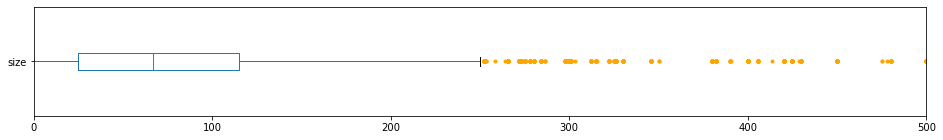

In [196]:
red_square = dict(markerfacecolor='orange', markeredgecolor='orange', marker='.')
df['size'].plot(kind='box', xlim=(0, 500), vert=False, flierprops=red_square, figsize=(16,2));
# Drop size outliner
df.drop(df[ (df['size'] <= 0.) | (df['size'] > 400.) ].index, axis=0, inplace=True)

In [197]:
# Drop size outliner
df.drop(df[ (df['size'] <= 0.) | (df['size'] > 400.) ].index, axis=0, inplace=True)

### 1.2.2. Extract information from  Amenities strings
What the hosts offer the guests usually take up a huge part of the price. But the variable of amenities comes as a dictionary of string. We have to think of a way to extract the determining information from them. 

In [198]:
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)
results.most_common(30)

[('Wifi', 51224),
 ('Heating', 50702),
 ('Smoke detector', 50122),
 ('Essentials', 50031),
 ('Kitchen', 47877),
 ('Carbon monoxide detector', 45946),
 ('Hangers', 45164),
 ('Air conditioning', 43309),
 ('Shampoo', 43221),
 ('Hair dryer', 42205),
 ('Iron', 41327),
 ('TV', 40769),
 ('Laptop friendly workspace', 39552),
 ('Washer', 36960),
 ('Dryer', 36749),
 ('Hot water', 33037),
 ('Fire extinguisher', 28637),
 ('Refrigerator', 25941),
 ('Self check-in', 24996),
 ('Microwave', 24689),
 ('Bed linens', 24261),
 ('Stove', 22860),
 ('Oven', 22456),
 ('Dishes and silverware', 22385),
 ('Coffee maker', 22208),
 ('Cable TV', 20976),
 ('Long term stays allowed', 20484),
 ('Cooking basics', 19261),
 ('Family/kid friendly', 19131),
 ('First aid kit', 18068)]

In [199]:
# There are some amenities that are not offered by around half of the host and they might have a influence on price that can be observed 
df['TV'] = df['amenities'].str.contains('TV')
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['Washer'] = df['amenities'].str.contains('Washer')
df['Dryer'] = df['amenities'].str.contains('Dryer')
df['Hot_water'] = df['amenities'].str.contains('Hot water')
df.drop(['amenities'], axis=1, inplace=True)

### 1.2.3. Use the distance to the Boston center instaed of latitude and longitude
The center point of Bosotn is (42.347345, -71.082503) and this distrct is almost the most expensive place in Boston. The closer the houses get to this place, the higherthe prices will be.

In [200]:
def distance_to_prudential(lat, lon):
    prudential_center = (42.347345, -71.082503)
    accommodation = (lat, lon)
    return great_circle(prudential_center, accommodation).km

df['distance'] = df.apply(lambda x: distance_to_prudential(x.latitude, x.longitude), axis=1)

In [201]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

### 1.2.4 One hot coding
- Only keep important variables based on variables importance
- convert each category value into a new column and assigns a 1 or 0 (True/False) value to the column.

In [203]:
deleted_columns = ["id","last_scraped","host_id","host_since","host_location","host_acceptance_rate","host_verifications",
                   "neighbourhood_cleansed","maximum_nights","has_availability","availability_30","availability_60",
                   "availability_90", "number_of_reviews","number_of_reviews_ltm","review_scores_accuracy","review_scores_cleanliness",
                 "review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value",
                 "requires_license","is_business_travel_ready","require_guest_profile_picture","require_guest_phone_verification",
                  "calculated_host_listings_count","calculated_host_listings_count_entire_homes", 
                   "calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"]
df2 = df.drop(deleted_columns, axis = 1).copy()

In [204]:
# One hot encoding for categorical variables
for column in df2.columns:
    if df2[column].dtype == type(object):
        dummy = pd.get_dummies(df2[column], drop_first = True)
        dummy.columns = [column+'_'+x for x in dummy]
        df2 = df2.join(dummy)
        df2 = df2.drop(columns=[column])

# 2. Prices Modeling
## 2.1 Data Splitting
- plitting the data into 80% training data and 20% test data 

In [205]:
predictors = df2.copy()
predictors.drop(columns = 'price', inplace = True)
target = df[["price"]]

In [206]:
# Split data set into training and test
predictors = predictors.values
target = target.values
X_train,X_test,y_train,y_test = train_test_split(predictors,target,test_size=0.2,random_state=0)
sc = preprocessing.MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

## 2.2 Regressions (Linear, Ridge, and Lasso)
We will use Linear, Ridge, and Lasso, three regressions methods and then box plot to check the regressions models

In [243]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('Ridge', Ridge()))
# evaluate each model in turn
scores = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
    cv_results = -cross_val_score(model, X_train, y_train, cv=10, scoring=scoring)
    scores.append(np.sqrt(cv_results))
    names.append(name)    
scores[0] = [i for i in scores[0] if i < 20000]

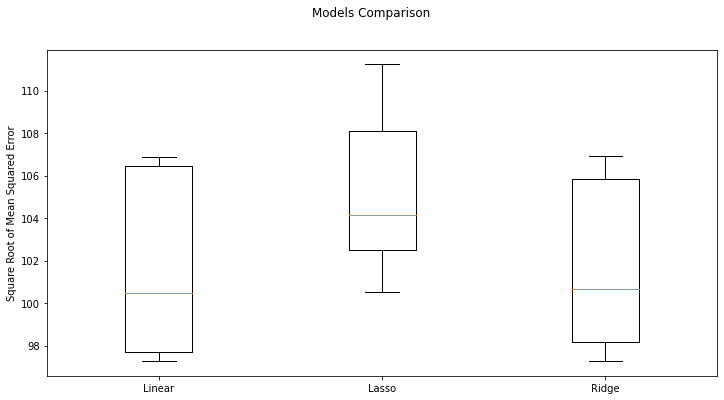

In [246]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(12,6))
fig.suptitle("Models Comparison")
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)
ax.set_ylabel('Square Root of Mean Squared Error')
plt.show()

In [214]:
model = sm.OLS(y_train, sm.add_constant(X_train).astype('float'))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     740.2
Date:                Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                        23:48:20   Log-Likelihood:            -2.5395e+05
No. Observations:               42041   AIC:                         5.080e+05
Df Residuals:                   41981   BIC:                         5.085e+05
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        223.6545    102.944      2.173      0.030      21.883     425.426
x1           273.2905     14.092     19.393      0.000     245.669     300.912
x2           296.5085      7.998     37.073      0.000     280.832     312.185
x3           472.2054     13.890     33.995      0.000     444.980     499.431
x4           -41.8946      8.268     -5.067      0.000     -58.101     -25.689
x5           -36.6244      9.173     -3.993      0.000     -54.603     -18.646
x6            -9.5923      8.113     -1.182      0.237     -25.493       6.309
x7            -0.6878      7.279     -0.094      0.925     -14.954      13.579
x8           195.9176      5.082     38.550      0.000     185.957     205.879
x9           199.2517      3.481     57.239      0.000     192.429     206.075
x10          -14.0367     19.403     -0.723      0.469     -52.067      23.993
x11         -256.3623     24.803    -10.336      0.000    -304.978    -207.747
x12           18.6126      1.382     13.472      0.000      15.905      21.320
x13           -3.5999      1.244     -2.894      0.004      -6.038      -1.162
x14            3.3457      4.765      0.702      0.483      -5.995      12.686
x15            1.0584      4.743      0.223      0.823      -8.238      10.355
x16          -23.7315      1.186    -20.016      0.000     -26.055     -21.408
x17         -143.0244      3.455    -41.394      0.000    -149.797    -136.252
x18            7.0743      1.297      5.456      0.000       4.533       9.616
x19           -4.7176     12.959     -0.364      0.716     -30.118      20.683
x20            3.7061      1.074      3.450      0.001       1.601       5.812
x21         -129.3525    101.756     -1.271      0.204    -328.796      70.091
x22          -27.3570    107.281     -0.255      0.799    -237.631     182.917
x23          -72.7098    101.904     -0.714      0.476    -272.444     127.025
x24          -66.4774    102.728     -0.647      0.518    -267.826     134.871
x25          -67.9676    102.262     -0.665      0.506    -268.404     132.469
x26          -45.2684    103.508     -0.437      0.662    -248.146     157.609
x27          -90.6200    113.784     -0.796      0.426    -313.640     132.400
x28         -182.5406    143.974     -1.268      0.205    -464.732      99.651
x29         -117.6698    101.767     -1.156      0.248    -317.135      81.795
x30         -171.9306    108.803     -1.580      0.114    -385.187      41.326
x31          -17.1674    143.993     -0.119      0.905    -299.396     265.061
x32          204.4860    113.780      1.797      0.072     -18.525     427.497
x33         -129.2269    101.858     -1.269      0.205    -328.871      70.417
x34         -142.6254    102.773     -1.388      0.165    -344.062      58.811
x35         -116.9079    109.922     -1.064      0.288    -332.357      98.541
x3

- **R sauqre** is 0.51, meaning 51% of total variance can be explained by linear model
- The Root of Mean Squared Error (MSE) 100 is a little too high, not good enough

## 2.3 Neural Nets Regression

In [223]:
clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100,100))
clf.fit(X_train, y_train)
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
print("RMSE of Training Data: %f" % (rmse_train))
print("RMSE of Testing Data: %f" % (rmse_test))

RMSE of Training Data: 25.762166
RMSE of Testing Data: 36.338294


## 2.4 XGBoost Tree Model
We will use the XGboost model to help to build the XGB regressors and the GridSearch function in Sklearn for the parameters tuning.

In [224]:
# create a baseline
booster = xgb.XGBRegressor()

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 1, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [226]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=1, gamma=0.2, learning_rate=0.1, 
                           max_depth=7, n_estimators=200)

# train
booster.fit(X_train, y_train)

# predict
result = booster.predict(X_test)
rmse = round(math.sqrt(sum((result.reshape(-1,1)-y_test.reshape(-1,1))**2)/len(y_test)),4)
print(f'The root of mean squared error for XGBoost Tree is {rmse}')

The root of mean squared error for XGBoost Tree is 32.6795


## 2.5 Random Forest Model

In [227]:
# instantiate
rf = RandomForestRegressor()

# train
rf.fit(X_train, y_train)

# predict
result = rf.predict(X_test)

rmse = round(math.sqrt(sum((result.reshape(-1,1)-y_test.reshape(-1,1))**2)/len(y_test)),4)
print(f'The root of mean squared error for Random Forest is {rmse}')

The root of mean squared error for Random Forest is 20.8127


## 2.6 KNN Model

In [231]:
knn = KNeighborsRegressor(n_neighbors=7)#1 is the best,yet overfit 
# fit the model using the training data and training targets
knn.fit(X_train, y_train)
preds_train = knn.predict(X_train)
preds_test = knn.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
print("RMSE of Training Data: %f" % (rmse_train))
print("RMSE of Testing Data: %f" % (rmse_test))

RMSE of Training Data: 38.300973
RMSE of Testing Data: 45.639623


## 2.7 Summary
After tranforming the some columns and deleting outliner, we get a relatively clean dataset. 
Then, we applied 7 models which are 4 supervised 
- Linear Regression
- Ridge Regression
- Lasso Regression
- Neural Nets Regression

and 3 unsupervised models
- XGBoost Tree
- Random Forest
- KNN

The first three simple regressions model don't work well since the RMSE is around 100. And the random forest model works the bese regards to RMSE. 



# 3. Insights and Recommendations

## 3.1 Insights
Even though the number of property in Back Bay or Downtown is much more than other areas, the graph shows that the North East Boston is actually hosting most customers per property based on our assumption. From this interesting phenomenon we can see how Airbnb interact the nature of Boston. First of all, the iconic attractions and tourist destinations are mostly located in the entertainment and downtown area, therefore, this geographic distribution fosters numerous Airbnb property. However, from a customer's perspective, staying in such area is not necessarily the best choice due to price consideration. This is where the North East Boston comes in and plays an important role. Its distance from the central Boston is neither too far to cause painful traffic nor too close to become unaffordable. Moreover, it is the closest district from the airport, which makes it even more favorable among all the other district. From this point of view, we can conclude that Airbnb is affecting the neighborhoods by chaneling more tourists to the North East Boston area, which will help improve the area's economics.

we can see that in past 10 years, the popularity of Airbnb is growing gradually, but it has slowed down and even shows signs of decline in recent years. The using of Airbnb reaches peaks around summer holidays and reach the bottom around December. That shows a clear pattern.

As the model indicated, if a property can accommodate more people, has more bathrooms or/and bedrooms, has higher cleaning fees, has cooking basics, is closer to the Prudential Center, is family/kids friendly, whose host has a profile picture, is renting the entire place, allows instant book etc., its price on average will be higher. 

## 3.2 Recommendations
For hosts:
- Pay attentionto the location of the houses. If the location is near the center Boston, feel free to price the house a little higher and if it's the opposite, try to avoid price the houses too high.
- People are willing to pay higher price for clean and convenient place. Make sure the good cleanliness in the houses and highlight this in their house descriptions.
- It helps to make the house more attractive if house description includes the distance to central Boston or stations, good cleanliness, family/ kids friendly, instant book etc..
- Friday and Saturday arae the two most popular days of a week and late spring and summer are the most seasons in a year. So, the hosts can charge more during the 'hot' time. 

For Airbnb
- With the help of our price models, Airbnb can know the market better and provide appropriate price suggestions for hosts.
- Knowing the factors that influence the price and popularity of houses help Airbnb make better promotion approaches and marketing strategies. For example, develping more available houses in popular districts such as Back Bay and South Boston Waterfront.